In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
skater_data = pd.read_csv("data/game_skater_stats.csv")
skater_info = pd.read_csv("data/player_info.csv")

# Drop any duplicate data
skater_data = skater_data.drop_duplicates(subset=['game_id','player_id'])
skater_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853404 entries, 0 to 945793
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   game_id               853404 non-null  int64  
 1   player_id             853404 non-null  int64  
 2   team_id               853404 non-null  int64  
 3   timeOnIce             853404 non-null  int64  
 4   assists               853404 non-null  int64  
 5   goals                 853404 non-null  int64  
 6   shots                 853404 non-null  int64  
 7   hits                  455297 non-null  float64
 8   powerPlayGoals        853404 non-null  int64  
 9   powerPlayAssists      853404 non-null  int64  
 10  penaltyMinutes        853404 non-null  int64  
 11  faceOffWins           853404 non-null  int64  
 12  faceoffTaken          853404 non-null  int64  
 13  takeaways             455297 non-null  float64
 14  giveaways             455297 non-null  float64
 15  

In [3]:
fields = ["timeOnIce","goals","assists","shots","hits",
          "powerPlayGoals","powerPlayAssists","shortHandedGoals","shortHandedAssists","shortHandedTimeOnIce","powerPlayTimeOnIce",
          "takeaways","giveaways","blocked","plusMinus",
        ]

# Create new df with aggregated data for each player
skater_stats = skater_data.groupby('player_id')[fields].sum().reset_index()

# Calculate the number of unique games played for each player in skater_data
skater_data['gamesPlayed'] = skater_data.groupby('player_id')['game_id'].transform('nunique')

# Ensuring the player_id in both DataFrames matches correctly
skater_stats = skater_stats.merge(skater_data[['player_id', 'gamesPlayed']].drop_duplicates(), on='player_id', how='left')

# Keep only data for players who have played more than 10 games
skater_stats = skater_stats[skater_stats.gamesPlayed >= 20]

In [4]:
drop_fields = ['birthCity', 'birthDate', 'birthStateProvince', 'height']
skater_info.drop(drop_fields, axis=1, inplace=True)


In [5]:
# Merge skater info and results
df = pd.merge(skater_info, skater_stats)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2569 entries, 0 to 2568
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   player_id             2569 non-null   int64  
 1   firstName             2569 non-null   object 
 2   lastName              2569 non-null   object 
 3   nationality           2569 non-null   object 
 4   primaryPosition       2569 non-null   object 
 5   height_cm             2569 non-null   float64
 6   weight                2569 non-null   float64
 7   shootsCatches         2569 non-null   object 
 8   timeOnIce             2569 non-null   int64  
 9   goals                 2569 non-null   int64  
 10  assists               2569 non-null   int64  
 11  shots                 2569 non-null   int64  
 12  hits                  2569 non-null   float64
 13  powerPlayGoals        2569 non-null   int64  
 14  powerPlayAssists      2569 non-null   int64  
 15  shortHandedGoals     

In [6]:
# Calculate per 60 rates
# timeOnIce in seconds / 60 to get to min then * 60 for p60
df['goals_p60'] = (df.goals / (df.timeOnIce / 60)) * 60 
df['assists_p60'] = (df.assists / (df.timeOnIce / 60)) * 60
df['shots_p60'] = (df.shots / (df.timeOnIce / 60)) * 60
df['hits_p60'] = (df.hits / (df.timeOnIce / 60)) * 60
df['takeaways_p60'] = (df.takeaways / (df.timeOnIce / 60))
df['giveaways_p60'] = (df.giveaways / (df.timeOnIce / 60))
df['blocked_p60'] = (df.blocked / (df.timeOnIce / 60)) * 60
df['plusMinus_p60'] = (df.plusMinus / (df.timeOnIce / 60)) * 60
df['avg_pp_TOI'] = (df.powerPlayTimeOnIce / 60) / df.gamesPlayed
df['avg_sh_TOI'] = (df.shortHandedTimeOnIce / 60) / df.gamesPlayed

def calc_special_teams_rates(df, special, points):
    # For rate to be valid player needs to have played at least 30 minutes in that situation
    # Otherwise set rate to 0 (were not a consistent special teams player)
    def calc_points_per60(special, points):
        return (df[f'{special}{points}'] / (df[f'{special}TimeOnIce'] / 60)) * 60
    
    return calc_points_per60(special, points) if df[f'{special}{points}'] > 3 else 0
    # return calc_points_per60(special, points) if df[f'{special}TimeOnIce'] > 10*60 else 0

df['ppg_p60'] = df.apply(calc_special_teams_rates, special="powerPlay", points="Goals", axis=1)
df['ppa_p60'] = df.apply(calc_special_teams_rates, special="powerPlay", points="Assists", axis=1)
df['shg_p60'] = df.apply(calc_special_teams_rates, special="shortHanded", points="Goals", axis=1)
df['sha_p60'] = df.apply(calc_special_teams_rates, special="shortHanded", points="Assists", axis=1)


df['ATOI_min'] = (df.timeOnIce / 60) / df.gamesPlayed 


In [7]:
df.sort_values(by="ppg_p60", ascending=False).head()

,player_id,firstName,lastName,nationality,primaryPosition,height_cm,weight,shootsCatches,timeOnIce,goals,assists,shots,hits,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,shortHandedTimeOnIce,powerPlayTimeOnIce,takeaways,giveaways,blocked,plusMinus,gamesPlayed,goals_p60,assists_p60,shots_p60,hits_p60,takeaways_p60,giveaways_p60,blocked_p60,plusMinus_p60,avg_pp_TOI,avg_sh_TOI,ppg_p60,ppa_p60,shg_p60,sha_p60,ATOI_min
906,8476477,Matt,Puempel,CAN,LW,185.42,205.0,L,52090,11,5,94,59.0,4,0,0,0,37,2771,17.0,13.0,28.0,-10,87,0.760223,0.345556,6.496448,4.077558,0.019581,0.014974,1.935112,-0.691112,0.530843,0.007088,5.196680,0.000000,0.0,0.0,9.978927
663,8477591,Josh,Jooris,CAN,RW,185.42,197.0,R,164743,23,32,302,237.0,4,1,0,3,17692,3418,79.0,53.0,108.0,-9,222,0.502601,0.699271,6.599370,5.178976,0.028772,0.019303,2.360040,-0.196670,0.256607,1.328228,4.212990,0.000000,0.0,0.0,12.368093
2478,8478109,Victor,Olofsson,SWE,RW,180.34,183.0,L,66049,22,24,148,12.0,13,6,0,0,434,11438,13.0,29.0,19.0,0,60,1.199110,1.308120,8.066738,0.654060,0.011809,0.026344,1.035595,0.000000,3.177222,0.120556,4.091624,1.888442,0.0,0.0,18.346944
2004,8459223,Pascal,Rheaume,CAN,C,185.42,210.0,L,141704,22,24,238,0.0,8,3,3,1,22245,7232,0.0,0.0,0.0,-23,201,0.558912,0.609722,6.046407,0.000000,0.000000,0.000000,0.000000,-0.584317,0.599668,1.844527,3.982301,0.000000,0.0,0.0,11.749917
2503,8480205,Emil,Bemstrom,SWE,C,182.88,190.0,R,43968,10,10,101,54.0,5,3,0,0,5,4947,11.0,18.0,18.0,-11,61,0.818777,0.818777,8.269651,4.421397,0.015011,0.024563,1.473799,-0.900655,1.351639,0.001366,3.638569,0.000000,0.0,0.0,12.013115


In [8]:
# Drop not useful non-rate stats now
df_copy = df.copy(deep=True)
df_drop_fields = ['timeOnIce','goals','assists','shots','hits','blocked','takeaways','giveaways','player_id','firstName','lastName',
                  'plusMinus','powerPlayGoals','powerPlayAssists','powerPlayTimeOnIce','shortHandedGoals','shortHandedAssists','shortHandedTimeOnIce',
                  'shg_p60','sha_p60']
df.drop(df_drop_fields, axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2569 entries, 0 to 2568
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nationality      2569 non-null   object 
 1   primaryPosition  2569 non-null   object 
 2   height_cm        2569 non-null   float64
 3   weight           2569 non-null   float64
 4   shootsCatches    2569 non-null   object 
 5   gamesPlayed      2569 non-null   int64  
 6   goals_p60        2569 non-null   float64
 7   assists_p60      2569 non-null   float64
 8   shots_p60        2569 non-null   float64
 9   hits_p60         2569 non-null   float64
 10  takeaways_p60    2569 non-null   float64
 11  giveaways_p60    2569 non-null   float64
 12  blocked_p60      2569 non-null   float64
 13  plusMinus_p60    2569 non-null   float64
 14  avg_pp_TOI       2569 non-null   float64
 15  avg_sh_TOI       2569 non-null   float64
 16  ppg_p60          2569 non-null   float64
 17  ppa_p60       

In [9]:
# Create categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

LE = LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)


In [10]:
df.shape

(2569, 19)

In [11]:
df.describe()

,nationality,primaryPosition,height_cm,weight,shootsCatches,gamesPlayed,goals_p60,assists_p60,shots_p60,hits_p60,takeaways_p60,giveaways_p60,blocked_p60,plusMinus_p60,avg_pp_TOI,avg_sh_TOI,ppg_p60,ppa_p60,ATOI_min
count,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000,2569.000000
mean,10.148696,1.319969,185.714636,202.625924,0.365123,330.112106,0.483740,0.793061,5.714752,3.026727,0.011945,0.013755,1.447879,-0.230643,1.251265,1.079233,0.577050,1.180162,14.528983
std,8.399794,1.063224,5.319509,15.732448,0.481558,296.449579,0.331312,0.384612,2.061721,3.793409,0.012575,0.014179,1.601251,0.545435,1.205654,0.963051,0.785770,1.315398,4.136786
min,0.000000,0.000000,162.560000,154.000000,0.000000,20.000000,0.000000,0.000000,0.604128,0.000000,0.000000,0.000000,0.000000,-4.473439,0.000000,0.000000,0.000000,0.000000,2.682500
25%,3.000000,0.000000,182.880000,191.000000,0.000000,84.000000,0.204417,0.521448,4.148899,0.000000,0.000000,0.000000,0.000000,-0.509091,0.188156,0.172667,0.000000,0.000000,11.563773
50%,4.000000,1.000000,185.420000,202.000000,0.000000,234.000000,0.443326,0.743611,5.672269,1.735454,0.008739,0.010862,1.069494,-0.155317,0.854217,0.886622,0.000000,0.874715,14.452370
75%,20.000000,2.000000,187.960000,213.000000,1.000000,511.000000,0.721735,1.014364,7.076194,4.707840,0.021303,0.024153,2.350308,0.117286,2.078109,1.729136,1.174577,2.244035,17.405536
max,22.000000,3.000000,205.740000,265.000000,1.000000,1576.000000,1.909477,2.825197,13.608247,26.372016,0.069354,0.070051,7.783137,1.887122,6.278627,4.607859,5.196680,6.452769,26.786228


In [12]:
# Normalize data
scale = StandardScaler()
scaled_data = pd.DataFrame(scale.fit_transform(df))

# Adding feature names to the scaled_data dataframe 
scaled_data.set_axis(df.columns,axis=1,inplace=True)

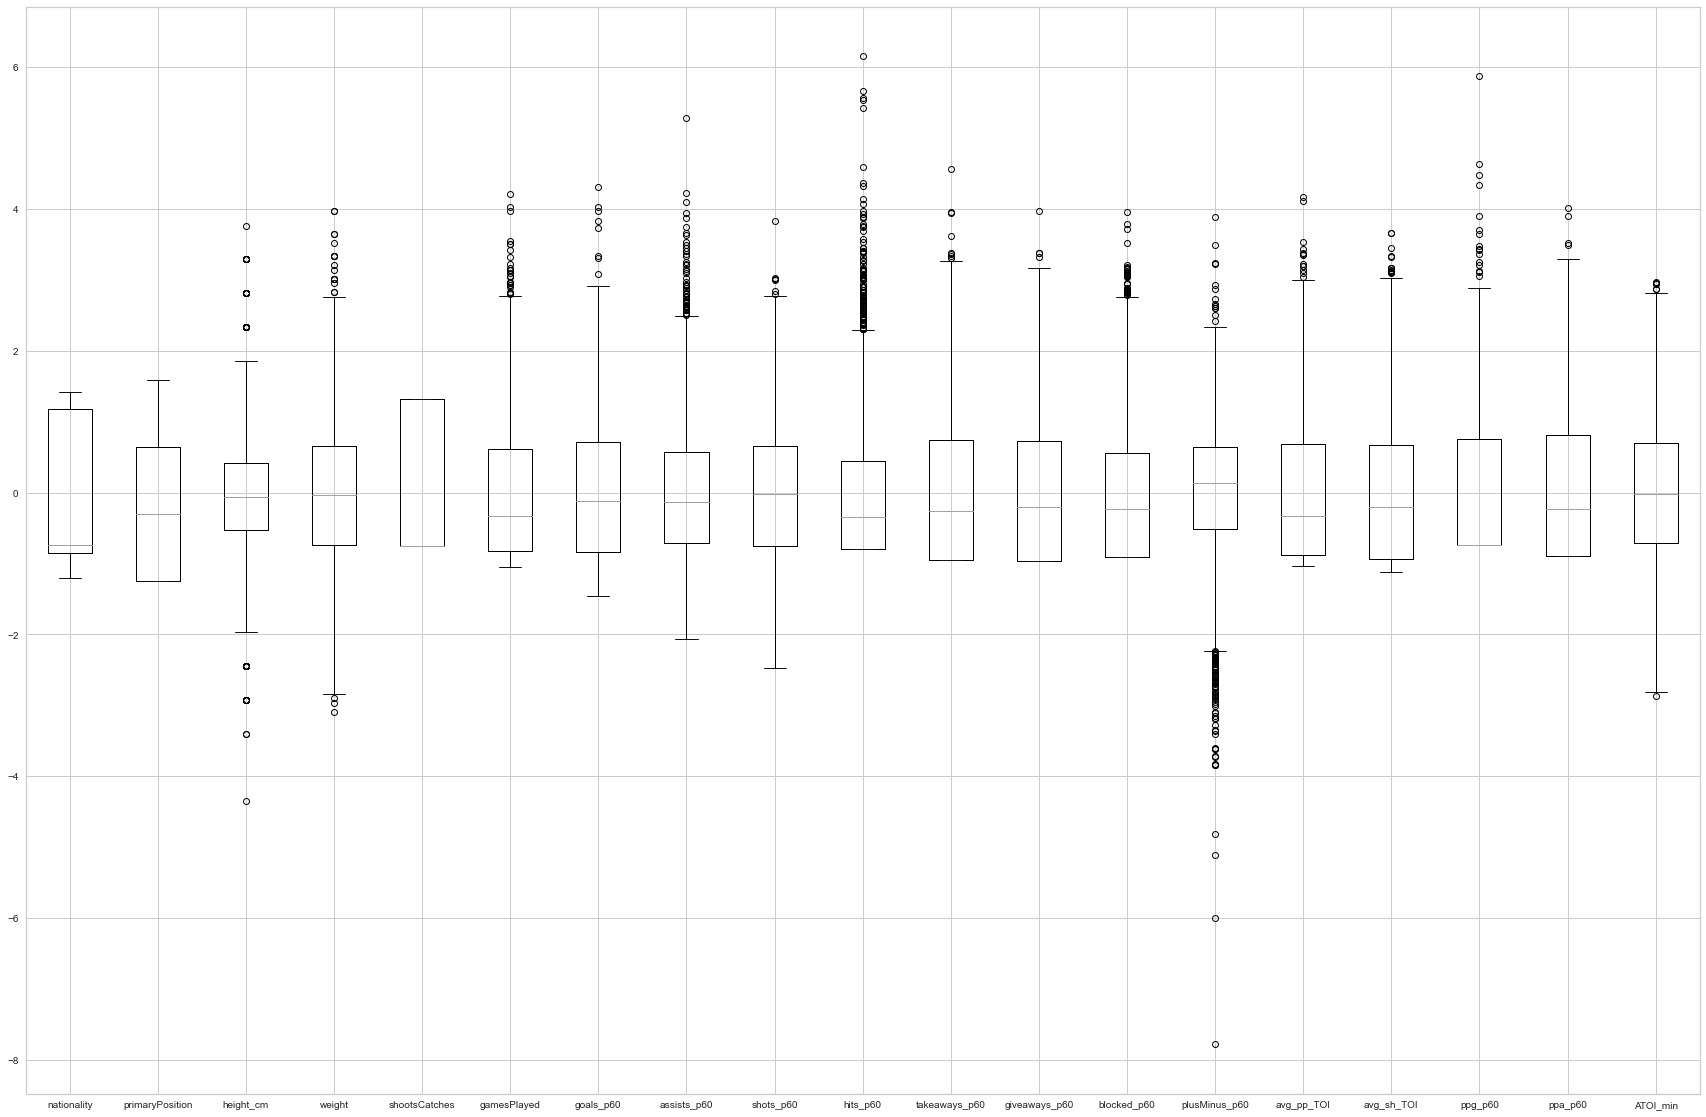

In [13]:
scaled_data.boxplot(figsize=(30,20))
plt.show()

# Note that there are some outliers. However at this moment I don't consider it necessary to drop many
# I handled some of the outliers in my rate calculations and player selection criteria (min N games played)
# scaled_data.drop(scaled_data[scaled_data.values > val].index, inplace=True) if needed


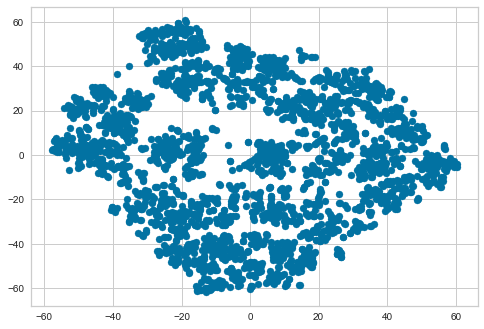

In [14]:
model = TSNE(random_state=1)
transformed = model.fit_transform(scaled_data)
x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x,y)
plt.show()

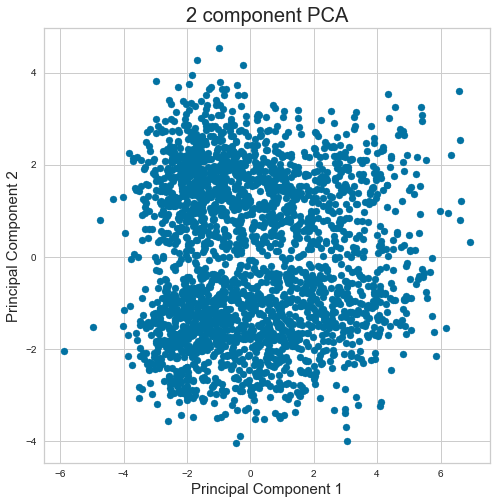

In [15]:
pca = PCA(n_components=2, random_state=1)
pca.fit(scaled_data)
pca_df = pd.DataFrame(pca.transform(scaled_data), columns=(['Principal Component 1', 'Principal Component 2']))
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(pca_df['Principal Component 1'],
            pca_df['Principal Component 2']);


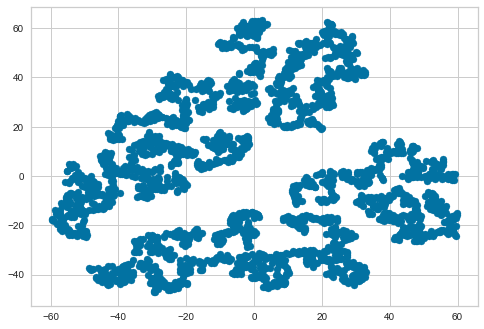

In [16]:
model = TSNE(random_state=1)
transformed = model.fit_transform(pca_df)
x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x,y)
plt.show()


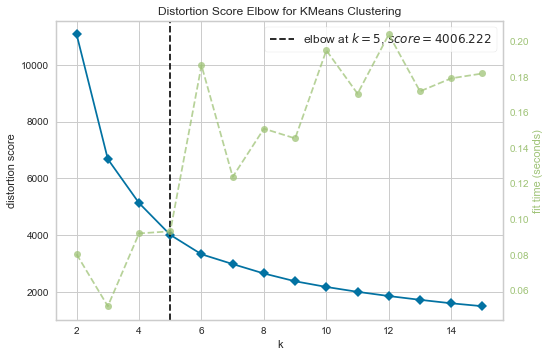

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
Elbow_M = KElbowVisualizer(KMeans(random_state=1), k=15)
Elbow_M.fit(pca_df)
Elbow_M.show()

In [18]:
nClusters = 8

kmeans = KMeans(n_clusters=nClusters, random_state=1)
clusters_predicted = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['Cluster'] = clusters_predicted

# Adding the Cluster variables to the original dataframe to be able to visualize and profile the clusters.
scaled_data["Cluster"] = clusters_predicted

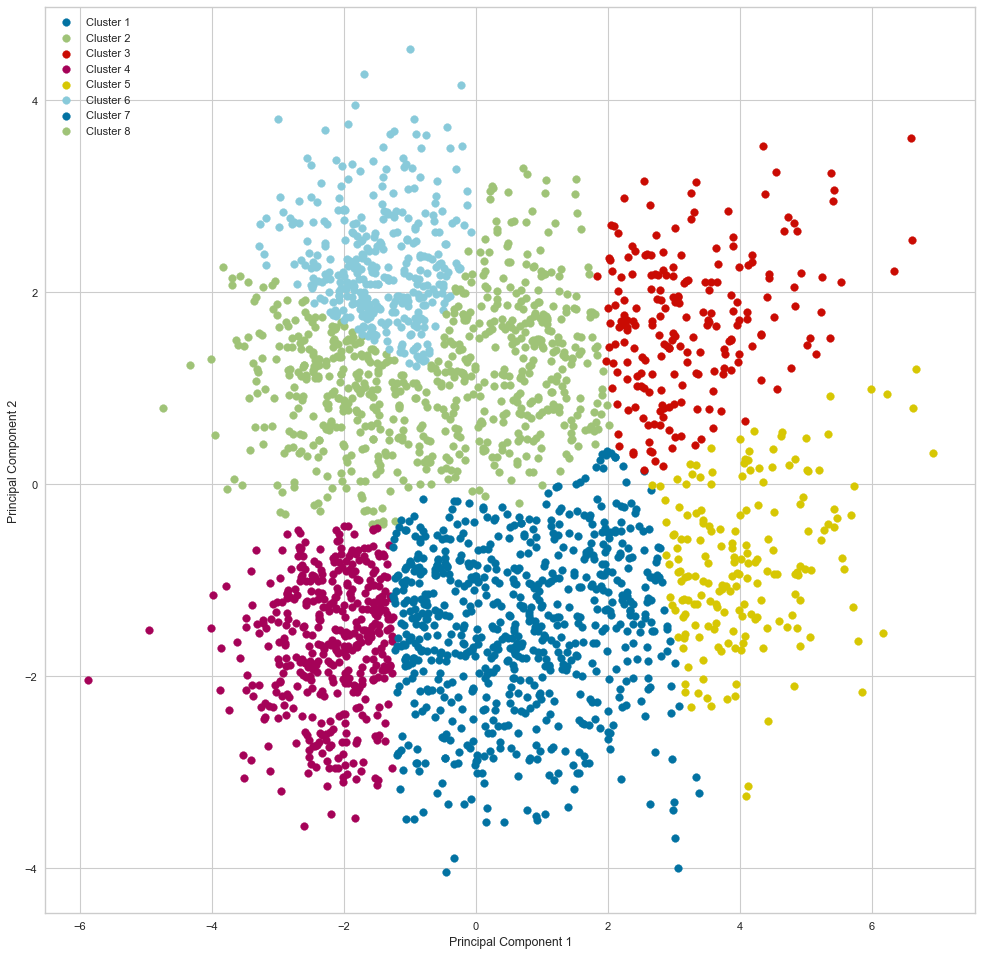

In [19]:
cluster_dfs = []
for x in sorted(pca_df.Cluster.unique()):
    cluster_dfs.append(pca_df[pca_df.Cluster == x])

figure(figsize=(15, 15), dpi=80)


for i, val in enumerate(cluster_dfs):
    plt.scatter(val['Principal Component 1'], val['Principal Component 2'], label=f'Cluster {i+1}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

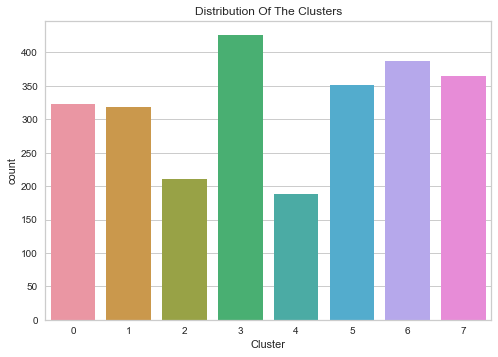

In [20]:
pl = sns.countplot(x=scaled_data["Cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

Text(0.5, 1.0, 'Hits')

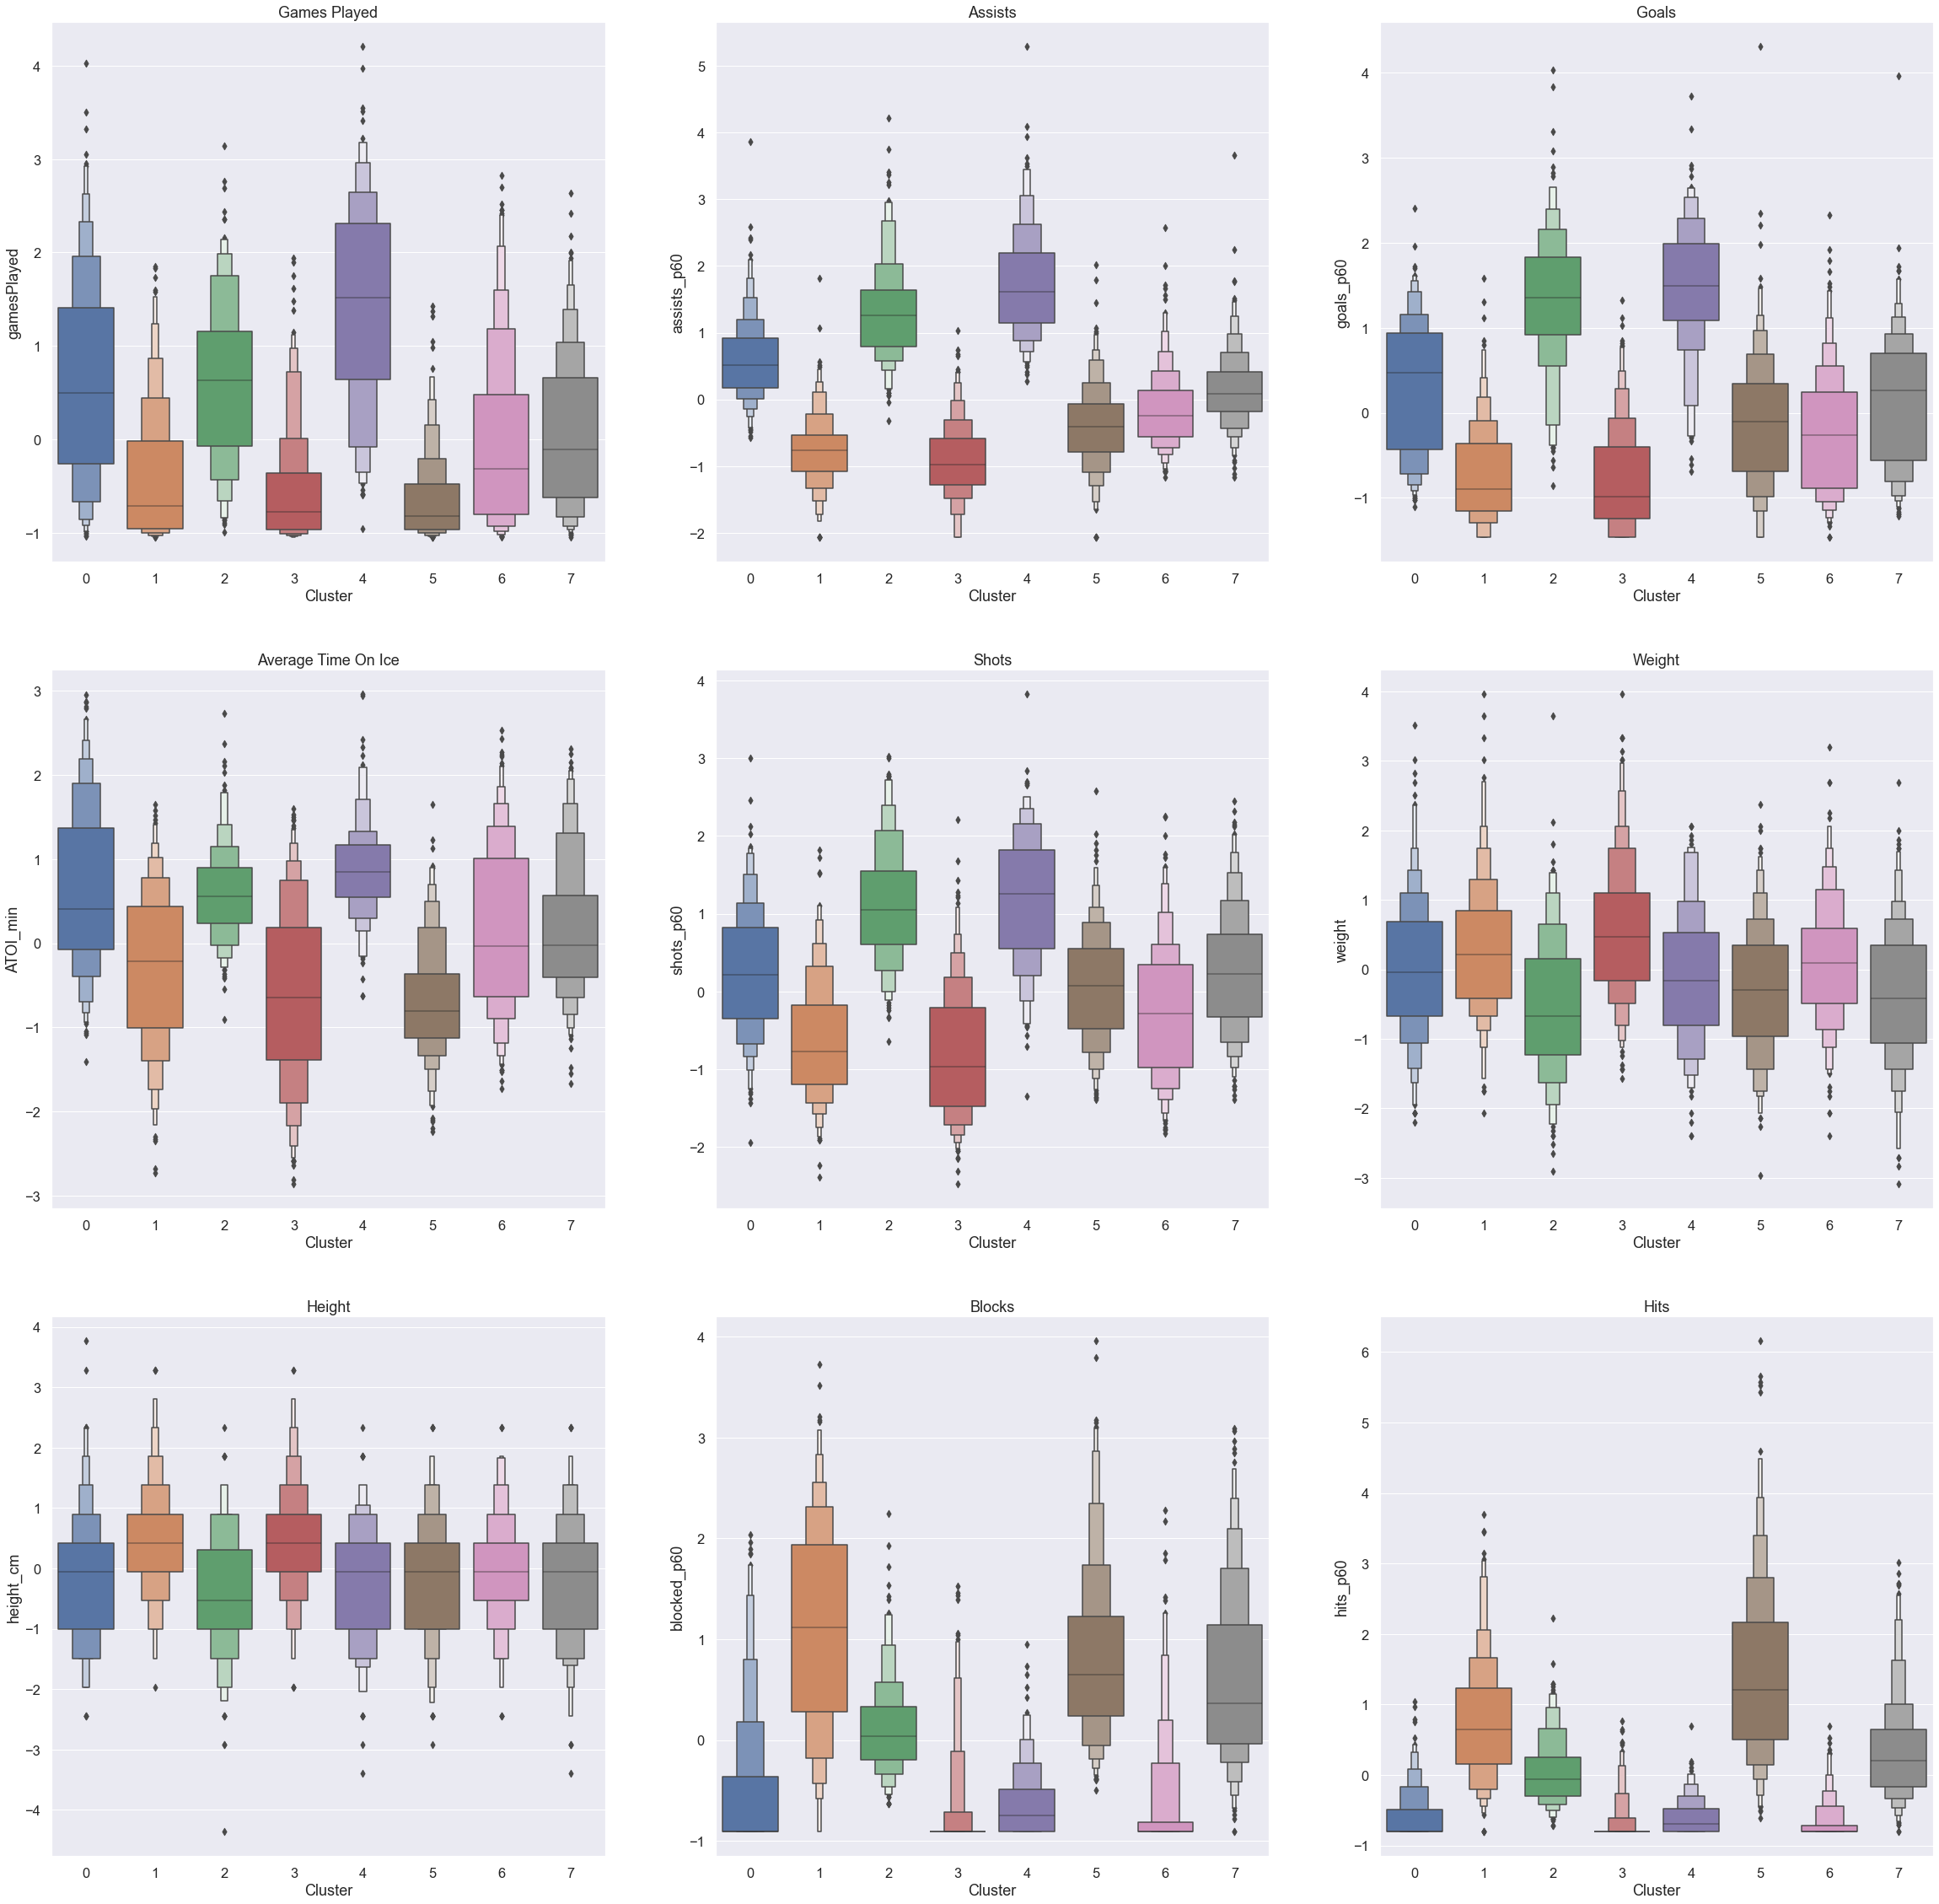

In [21]:
# Plotting scaled data
sns.set(font_scale=1.5)
fig, axes = plt.subplots(3, 3, figsize=(40,40))

sns.boxenplot(data=scaled_data, x='Cluster', y='gamesPlayed', ax=axes[0,0]).set_title('Games Played')
sns.boxenplot(data=scaled_data, x='Cluster', y='assists_p60', ax=axes[0,1]).set_title('Assists')
sns.boxenplot(data=scaled_data, x='Cluster', y='goals_p60', ax=axes[0,2]).set_title('Goals')
sns.boxenplot(data=scaled_data, x='Cluster', y='ATOI_min', ax=axes[1,0]).set_title('Average Time On Ice')
sns.boxenplot(data=scaled_data, x='Cluster', y='shots_p60', ax=axes[1,1]).set_title('Shots')
sns.boxenplot(data=scaled_data, x='Cluster', y='weight', ax=axes[1,2]).set_title('Weight')
sns.boxenplot(data=scaled_data, x='Cluster', y='height_cm', ax=axes[2,0]).set_title('Height')
sns.boxenplot(data=scaled_data, x='Cluster', y='blocked_p60', ax=axes[2,1]).set_title('Blocks')
sns.boxenplot(data=scaled_data, x='Cluster', y='hits_p60', ax=axes[2,2]).set_title('Hits')
# sns.boxenplot(data=scaled_data, x='Cluster', y='plusMinus_p60', ax=axes[2,1]).set_title('Plus Minus')


Text(0.5, 1.0, 'Hits')

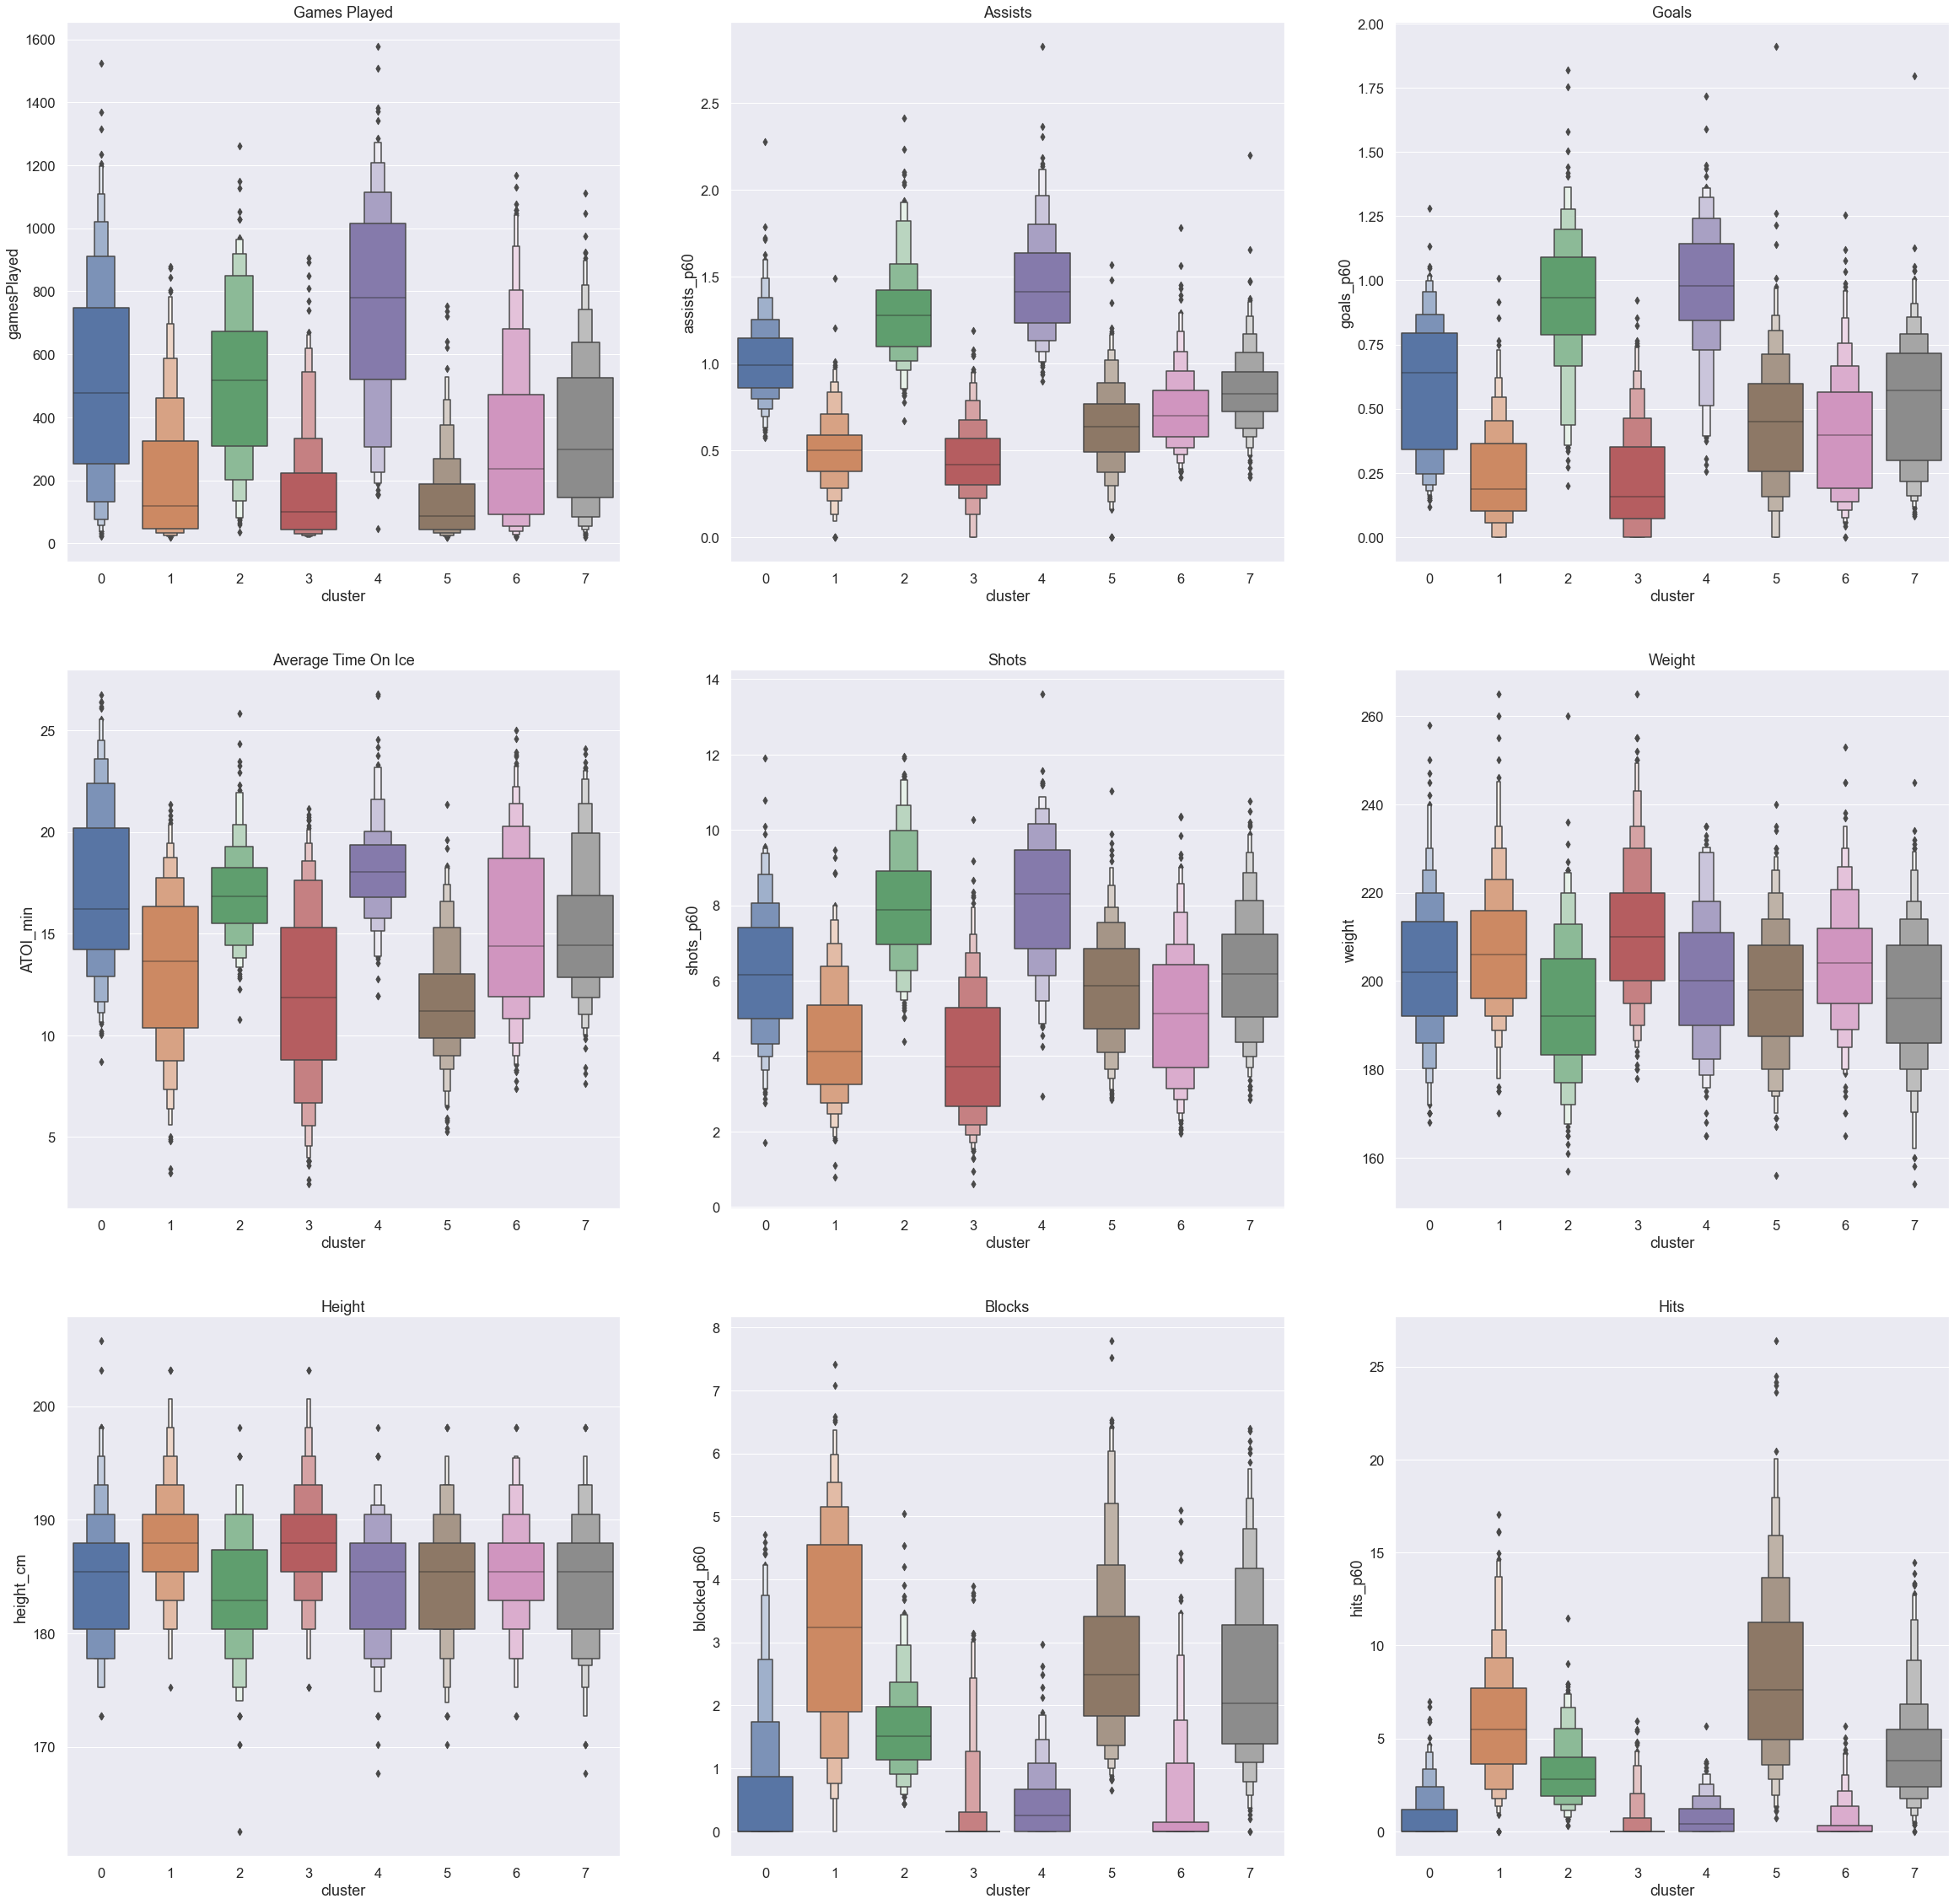

In [22]:
# Assign the cluster labels to the original DataFrame
df_copy['cluster'] = clusters_predicted

# Plot using original, non-scaled data
fig, axes = plt.subplots(3, 3, figsize=(40,40))

sns.boxenplot(data=df_copy, x='cluster', y='gamesPlayed', ax=axes[0,0]).set_title('Games Played')
sns.boxenplot(data=df_copy, x='cluster', y='assists_p60', ax=axes[0,1]).set_title('Assists')
sns.boxenplot(data=df_copy, x='cluster', y='goals_p60', ax=axes[0,2]).set_title('Goals')
sns.boxenplot(data=df_copy, x='cluster', y='ATOI_min', ax=axes[1,0]).set_title('Average Time On Ice')
sns.boxenplot(data=df_copy, x='cluster', y='shots_p60', ax=axes[1,1]).set_title('Shots')
sns.boxenplot(data=df_copy, x='cluster', y='weight', ax=axes[1,2]).set_title('Weight')
sns.boxenplot(data=df_copy, x='cluster', y='height_cm', ax=axes[2,0]).set_title('Height')
sns.boxenplot(data=df_copy, x='cluster', y='blocked_p60', ax=axes[2,1]).set_title('Blocks')
sns.boxenplot(data=df_copy, x='cluster', y='hits_p60', ax=axes[2,2]).set_title('Hits')

In [40]:
df_copy[df_copy.cluster == 2].sort_values(by="gamesPlayed", ascending=False).head(50)

,player_id,firstName,lastName,nationality,primaryPosition,height_cm,weight,shootsCatches,timeOnIce,goals,assists,shots,hits,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,shortHandedTimeOnIce,powerPlayTimeOnIce,takeaways,giveaways,blocked,plusMinus,gamesPlayed,goals_p60,assists_p60,shots_p60,hits_p60,takeaways_p60,giveaways_p60,blocked_p60,plusMinus_p60,avg_pp_TOI,avg_sh_TOI,ppg_p60,ppa_p60,shg_p60,sha_p60,ATOI_min,cluster
207,8470606,Dustin,Brown,USA,RW,182.88,216.0,R,1367511,317,378,3267,2524.0,101,93,8,10,104144,198308,340.0,470.0,270.0,-9,1262,0.834509,0.995093,8.600443,6.644480,0.014918,0.020621,0.710780,-0.023693,2.618965,1.375383,1.833512,1.688283,0.276540,0.345675,18.060103,2
552,8470794,Joe,Pavelski,USA,C,180.34,195.0,R,1305803,414,468,3311,1022.0,145,182,10,7,83266,219732,555.0,639.0,810.0,109,1150,1.141367,1.290241,9.128176,2.817577,0.025502,0.029361,2.233109,0.300505,3.184522,1.206754,2.375621,2.981814,0.432349,0.302645,18.924681,2
304,8470543,Chris,Kunitz,CAN,LW,182.88,195.0,L,1083794,286,385,2340,1824.0,87,84,6,3,29194,170671,255.0,289.0,256.0,185,1128,0.949996,1.278841,7.772695,6.058716,0.014117,0.015999,0.850346,0.614508,2.521735,0.431353,1.835110,1.771830,0.739878,0.000000,16.013505,2
234,8473473,Milan,Lucic,CAN,LW,190.50,236.0,L,1002217,225,352,1728,2511.0,48,74,0,0,1452,124497,302.0,591.0,263.0,113,1052,0.808208,1.264397,6.207039,9.019604,0.018080,0.035382,0.944706,0.405900,1.972386,0.023004,1.387985,2.139811,0.000000,0.000000,15.877963,2
563,8471276,David,Krejci,CZE,C,182.88,186.0,R,1118542,240,540,1877,584.0,55,143,4,8,45104,149195,430.0,445.0,468.0,140,1029,0.772434,1.737977,6.041078,1.879590,0.023066,0.023870,1.506247,0.450587,2.416505,0.730547,1.327122,3.450518,0.319262,0.638524,18.116974,2
729,8470655,David,Backes,USA,RW,190.50,221.0,R,1069487,261,332,2288,2176.0,70,68,4,6,80612,138585,361.0,248.0,528.0,60,1028,0.878552,1.117545,7.701636,7.324633,0.020253,0.013913,1.777301,0.201966,2.246839,1.306939,1.818379,1.766425,0.178633,0.267950,17.339283,2
635,8473544,Derick,Brassard,CAN,C,185.42,202.0,L,936191,211,340,1962,1286.0,59,106,0,0,5794,148372,400.0,393.0,202.0,-17,969,0.811373,1.307426,7.544614,4.945145,0.025636,0.025187,0.776765,-0.065371,2.551978,0.099656,1.431537,2.571914,0.000000,0.000000,16.102356,2
90,8471217,Andrew,Ladd,CAN,LW,190.50,200.0,L,961337,250,291,2135,1077.0,48,53,6,7,64002,117480,299.0,334.0,326.0,35,962,0.936196,1.089732,7.995115,4.033133,0.018662,0.020846,1.220800,0.131067,2.035343,1.108836,1.470889,1.624106,0.337489,0.393738,16.655180,2
279,8473422,Nick,Foligno,USA,LW,182.88,202.0,L,933059,204,282,1754,1854.0,47,72,0,1,31377,115011,378.0,285.0,486.0,-7,949,0.787088,1.088034,6.767418,7.153245,0.024307,0.018327,1.875123,-0.027008,2.019863,0.551054,1.471164,2.253697,0.000000,0.000000,16.386705,2
17,8474190,Wayne,Simmonds,CAN,RW,187.96,185.0,R,906854,257,260,2057,1500.0,103,70,3,1,21161,142006,304.0,317.0,381.0,-92,947,1.020230,1.032140,8.165813,5.954652,0.020113,0.020974,1.512482,-0.365219,2.499226,0.372422,2.611157,1.774573,0.000000,0.000000,15.960120,2


In [39]:
df_copy[df_copy.lastName == "Crosby"]

,player_id,firstName,lastName,nationality,primaryPosition,height_cm,weight,shootsCatches,timeOnIce,goals,assists,shots,hits,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,shortHandedTimeOnIce,powerPlayTimeOnIce,takeaways,giveaways,blocked,plusMinus,gamesPlayed,goals_p60,assists_p60,shots_p60,hits_p60,takeaways_p60,giveaways_p60,blocked_p60,plusMinus_p60,avg_pp_TOI,avg_sh_TOI,ppg_p60,ppa_p60,shg_p60,sha_p60,ATOI_min,cluster
298,8471675,Sidney,Crosby,CAN,C,180.34,200.0,L,1363766,504,874,3480,647.0,150,346,3,7,30593,288217,390.0,560.0,311.0,178,1092,1.330434,2.307141,9.186327,1.707918,0.017158,0.024638,0.820962,0.469875,4.398916,0.466926,1.873588,4.321744,0.0,0.823718,20.814499,4
